## Part 1 Data Wrangling

### User Engagement Data

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
%matplotlib inline

engagement = pd.read_csv('/Users/oliverbohler/Desktop/relax_challenge/takehome_user_engagement.csv')

In [180]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [182]:
engagement.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [184]:
engagement['time_stamp'] = pd.to_datetime(
    engagement['time_stamp'], format='%Y-%m-%d %H:%M:%S'
)

In [186]:
print('There were {} users and {} total logins'.format(
    engagement['user_id'].nunique(), len(engagement)
))


There were 8823 users and 207917 total logins


In [188]:
def logins_in_days(df, days=7, logins=3):
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    passed_days = df['date'].diff(periods=logins-1)
    return any(passed_days <= timedelta(days=days))

In [190]:
adopted = engagement.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'

/var/folders/0z/41_yxdy57v5gqbv0vhg6ky780000gn/T/ipykernel_14912/1337817899.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adopted = engagement.groupby('user_id').apply(logins_in_days)


In [191]:
print('There were {} adopted users out of {} users'.format(
    sum(adopted), len(adopted)))

There were 1656 adopted users out of 8823 users


### 1.2 The User Data

In [192]:
users = pd.read_csv('/Users/oliverbohler/Desktop/relax_challenge/takehome_users.csv', encoding='ISO-8859-1')

In [193]:
users.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [198]:
users.drop(columns=['name','email'], inplace = True)

In [200]:
users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [202]:
users['org_id'].value_counts()

org_id
0      319
1      233
2      201
3      168
4      159
      ... 
396      9
397      8
400      8
386      7
416      2
Name: count, Length: 417, dtype: int64

In [204]:
users['invited_by_user_id'].value_counts().head()

invited_by_user_id
10741.0    13
2527.0     12
1525.0     11
11770.0    11
2308.0     11
Name: count, dtype: int64

In [206]:
users = users.drop(['org_id', 'invited_by_user_id'], axis=1)

By leveraging the creation time and last session time, we can derive two meaningful features that may contribute to predicting user adoption.

The length of time a user has engaged with the software could play a role in determining whether they become an "adopted user." In other words, individuals who have been using the platform for an extended period might have a higher likelihood of adoption compared to those who recently signed up.

Additionally, user adoption trends may fluctuate over time, making it valuable to examine account age (calculated from the creation time) to gain further insights

In [208]:
users['creation_time'] = pd.to_datetime(
    users['creation_time'], format='%Y-%m-%d %H:%M:%S')
users['last_session_creation_time'] = pd.to_datetime(
    users['last_session_creation_time'], unit='s')
# calculate user history, defined as number of days between account creation and last use
users['history'] = users['last_session_creation_time'] - users['creation_time']
users['history'] = users['history'].dt.days

latest = max(users['creation_time'])
users['account_age'] = latest - users['creation_time']
users['account_age'] = users['account_age'].dt.days
users = users.drop(['creation_time', 'last_session_creation_time'], axis=1)

In [210]:
users.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history,account_age
0,1,GUEST_INVITE,1,0,0.0,38
1,2,ORG_INVITE,0,0,136.0,196
2,3,ORG_INVITE,0,0,0.0,437
3,4,GUEST_INVITE,0,0,1.0,374
4,5,GUEST_INVITE,0,0,5.0,498


In [212]:
users = users.set_index('object_id')
users.index.name = 'user_id'
data = pd.concat([users, adopted], axis=1, join='inner')
data['adopted_user'] = data['adopted_user'].astype(int)

## 2 Exploratory Data Analysis

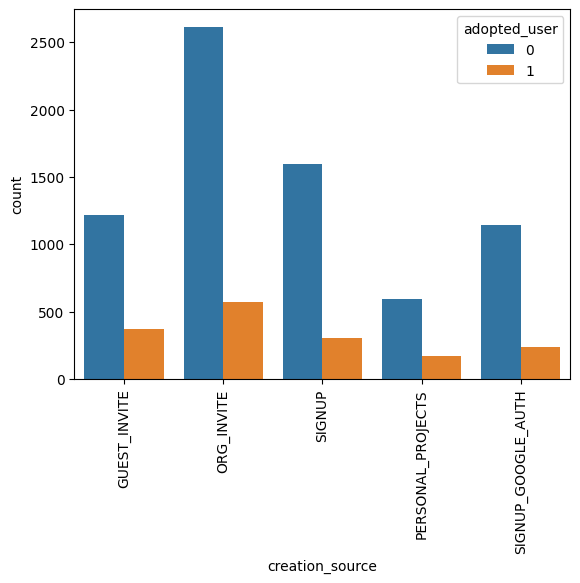

In [258]:
plot = sns.countplot(x='creation_source', data=data, hue='adopted_user')
plot = plt.xticks(rotation=90)
plt.show()

In [216]:
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(data['creation_source'], data['adopted_user'])
results = chi2_contingency(crosstab)
print('chi2 = {}\tp = {}'.format(results[0], results[1]))

chi2 = 41.27933208242451	p = 2.3526508745340972e-08


In [218]:
data.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x)/len(x))

creation_source
GUEST_INVITE          0.232368
ORG_INVITE            0.180050
PERSONAL_PROJECTS     0.225131
SIGNUP                0.159115
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted_user, dtype: float64

In [220]:
data.groupby('opted_in_to_mailing_list')['adopted_user'].apply(lambda x: sum(x)/len(x))

opted_in_to_mailing_list
0    0.185994
1    0.192722
Name: adopted_user, dtype: float64

In [222]:
def z_test(df, col, target='adopted_user'):
    from statsmodels.stats.weightstats import CompareMeans
    opted_in = df.loc[data[col]==1, target]
    opted_out = df.loc[data[col]==0, target]
    z_data = CompareMeans.from_data(opted_in, opted_out)
    z, p = CompareMeans.ztest_ind(z_data)
    print('For {}, z = {}, p = {}'.format(col, z, p))
z_test(data, 'opted_in_to_mailing_list')

For opted_in_to_mailing_list, z = 0.7029779128148235, p = 0.4820695142048762


In [224]:
data.groupby('enabled_for_marketing_drip')['adopted_user'].apply(lambda x: sum(x)/len(x))

enabled_for_marketing_drip
0    0.186982
1    0.191648
Name: adopted_user, dtype: float64

In [226]:
z_test(data, 'enabled_for_marketing_drip')

For enabled_for_marketing_drip, z = 0.40292649500940264, p = 0.6870022995069656


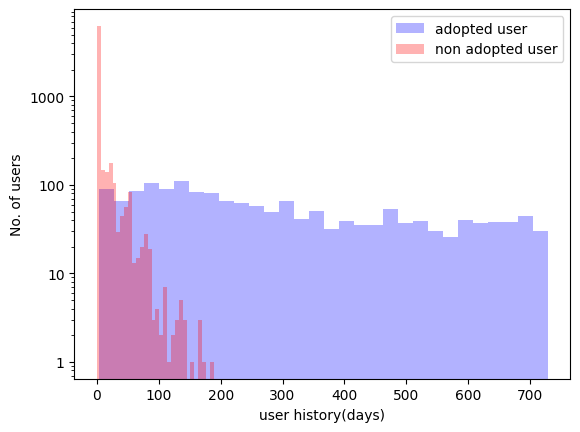

In [228]:
def plot_hist_days(df, col, xlabel):
    _ = plt.hist(df.loc[data['adopted_user']==1, col], 
                 bins=30, alpha=0.3, color='b', label='adopted user')
    _ = plt.hist(df.loc[data['adopted_user']==0, col], 
                 bins=30, alpha=0.3, color='r', label='non adopted user')
    _ = plt.yscale('log')
    _ = plt.legend()
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel('No. of users')
    _ = plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
    plt.show()
plot_hist_days(data, 'history', 'user history(days)')

The graph shows that the users with long history become more likely adopted users. An important graph to understand the specifics of the adopted users.

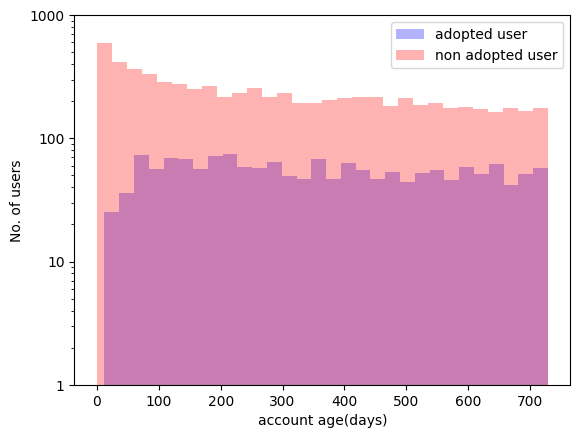

In [230]:
plot_hist_days(data, 'account_age', 'account age(days)')

The adoption rate is lower in new accounts. There is no extreme drop or spike in adoption rate over the past 2 years.

## Predictive Modeling

In [232]:
creation_source = pd.get_dummies(data['creation_source'], drop_first=True)
model_data = pd.concat([data, creation_source], axis=1).drop('creation_source', axis=1)
y = model_data['adopted_user']
X = model_data.drop('adopted_user', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

### Random Forest

In [234]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42, class_weight='balanced')

params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(X_train, y_train)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 100}
Best average precision was 0.9623700369708137


In [244]:
from sklearn.metrics import classification_report, accuracy_score
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=100
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy of test set was', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy of test set was 0.9524025385312783
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1792
           1       0.88      0.86      0.87       414

    accuracy                           0.95      2206
   macro avg       0.92      0.92      0.92      2206
weighted avg       0.95      0.95      0.95      2206



In [246]:
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

history                       0.895648
account_age                   0.088648
opted_in_to_mailing_list      0.003301
SIGNUP                        0.003050
enabled_for_marketing_drip    0.002900
ORG_INVITE                    0.002355
PERSONAL_PROJECTS             0.002157
SIGNUP_GOOGLE_AUTH            0.001942
dtype: float64


## XGBoost

In [263]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

print(f"Accuracy of test set: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Accuracy of test set: 0.9569
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1792
           1       0.91      0.86      0.88       414

    accuracy                           0.96      2206
   macro avg       0.94      0.92      0.93      2206
weighted avg       0.96      0.96      0.96      2206



/Users/oliverbohler/anaconda3/envs/clean_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:11:45] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [265]:
imp = pd.Series(xgb_clf.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

history                       0.828543
account_age                   0.036410
SIGNUP                        0.025780
opted_in_to_mailing_list      0.024960
SIGNUP_GOOGLE_AUTH            0.023115
enabled_for_marketing_drip    0.021332
PERSONAL_PROJECTS             0.020547
ORG_INVITE                    0.019315
dtype: float32


The analysis clearly shows that user history is the most influential factor in predicting adoption. Given this insight, a strategic approach to increasing the number of adopted users would be to encourage existing users to log in and engage with the software after they have had their accounts for some time.

The signup method also plays a significant role in adoption. When combining the importance of all four signup-related features, guest invitations and personal projects emerge as the most effective signup methods for driving user adoption. To capitalize on this, the company could implement initiatives such as incentivizing user invitations and promoting personal project collaboration within the platform.

While account age holds some predictive value, it is not a factor that can be influenced directly. On the other hand, marketing efforts such as mailing lists and marketing drip campaigns appear to have little impact on user adoption and may not be the most effective strategies to prioritize.

Additionally, XGBoost outperformed Random Forest slightly, further reinforcing the significance of these key factors in predicting user adoption.